In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

#display settings
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

# Introduction & Project Overview

# Part 1: Liability Modelling
## Setting Up Member Demographics and Assumptions

In [24]:
#Actuarial Assumptions
assumptions = {
    'discount_rate': 0.06,
    'salary_growth': 0.03,
    'retirement_age': 65,
    'mortality_improvement': 0.06,
    'benefit_accrual': 0.02
}

#Display Assumptions
print("Pension Fund Assumptions:")
print("-" * 40)
for key, value in assumptions.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

Pension Fund Assumptions:
----------------------------------------
Discount Rate: 0.06
Salary Growth: 0.03
Retirement Age: 65
Mortality Improvement: 0.06
Benefit Accrual: 0.02


In [25]:
# Create a sample pension plan membership
np.random.seed(42)  # For reproducibility
n_members = 1000  # Number of plan members
ages = np.random.randint(25,65,n_members)
max_possible_service = ages -18
years_of_service = [np.random.randint(0, min(max_years, 35) + 1) for max_years in max_possible_service]


members = pd.DataFrame({
    'member_id': range(1, n_members + 1),
    'current_age': ages,
    'current_salary': np.random.uniform(40000, 150000, n_members),
    'years_of_service': years_of_service
})

# Display first few members
print("\nSample Plan Members:")
members.head(10)


Sample Plan Members:


,member_id,current_age,current_salary,years_of_service
0,1,63,58481.562852,13
1,2,53,121056.111944,21
2,3,39,134907.678530,10
3,4,32,63841.378010,6
4,5,45,50528.601107,0
5,6,63,42600.244465,20
6,7,43,110616.865049,25
7,8,47,106780.343970,13
8,9,35,100136.715399,3
9,10,35,65514.180573,0


## Projecting Future Salary Function
### Function projects future salary by subtracting retirement age from current age to see how many years of working is left and then multiply current salary growth rate to current salary and years until retirement

In [ ]:
def calculate_total_years_of_service(years_of_service, current_age, retirement_age):
    '''
    Calculate the total years of service by adding the years of service

    Parameters: 
    - retirement_age: Age at retirement
    - years_of_service: Number of years in service
    - current_age: Current age

    Returns:
    - The total years of service
    '''
    if current_age >= retirement_age:
        return years_of_service
        
    # Only calculate if not retired yet
    years_until_retirement = retirement_age - current_age
    total_years = years_of_service + years_until_retirement
    return total_years

In [26]:
def project_final_salary(current_salary, current_age, retirement_age, salary_growth_rate):
    """
    Calculate what someone's salary will be at retirement.
    
    Parameters:
    - current_salary: Their salary today
    - current_age: Their age today
    - retirement_age: When they'll retire
    - salary_growth_rate: Annual salary growth (as decimal, e.g., 0.03 for 3%)
    
    Returns:
    - The projected salary at retirement
    """
    if current_age >= retirement_age:
        return current_salary
        
    years_until_retirement = retirement_age - current_age
    
    final_salary = current_salary * (1 + salary_growth_rate) ** years_until_retirement
    
    return final_salary

In [28]:
def calculate_pension_benefit(total_years, final_salary, benefit_accrual_rate):
    '''
    Calculate the pension benefit from total years worked at retirement, final salary and the benefit accrual rate

    Parameters: 
    - total_years_of_service: The total years they have worked up until retirement
    - final_salary: Their final salary at retirement
    - benefit_accrual_rate: The accrual rate

    Returns: 
    - The pension benefit in dollars ($)
    '''
    return benefit_accrual_rate * total_years * final_salary

In [31]:
# Get data for member 1 from our DataFrame
member_1 = members.iloc[0]  # Get first row

print("Member 1 Data:")
print(f"Current age: {member_1['current_age']}")
print(f"Current salary: ${member_1['current_salary']:,.2f}")
print(f"Current years of service: {member_1['years_of_service']}")
print()

# Step 1: Calculate total years at retirement
total_years = calculate_total_years_of_service(
    member_1['years_of_service'],
    member_1['current_age'],
    assumptions['retirement_age']
)
print(f"Total years at retirement: {total_years}")

# Step 2: Calculate final salary
final_sal = project_final_salary(
    member_1['current_salary'],
    member_1['current_age'],
    assumptions['retirement_age'],
    assumptions['salary_growth']
)
print(f"Final salary: ${final_sal:,.2f}")

# Step 3: Calculate annual pension benefit
annual_pension = calculate_pension_benefit(
    total_years,
    final_sal,
    assumptions['benefit_accrual']
)
print(f"Annual pension benefit: ${annual_pension:,.2f}")

Member 1 Data:
Current age: 63.0
Current salary: $58,481.56
Current years of service: 13.0

Total years at retirement: 15.0
Final salary: $62,043.09
Annual pension benefit: $18,612.93


Calculated Pension Obligations for All Members:
   current_age   final_salary  annual_pension
0           63   62043.090030    18612.927009
1           53  172597.069523   113914.065885
2           39  290940.721442   209477.319438
3           32  169328.736561   132076.414518
4           45   91260.274132    36504.109653


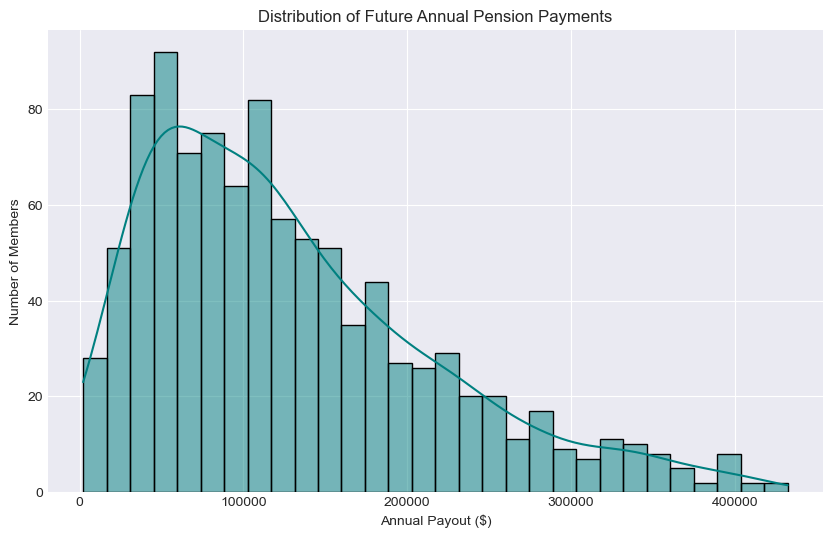

In [32]:
# --- APPLYING LOGIC TO THE WHOLE DATAFRAME ---

# 1. Vectorized calculation for Total Years at Retirement
# We can do column math directly: (Retirement Age - Current Age) + Current Service
members['years_to_retirement'] = assumptions['retirement_age'] - members['current_age']
members['total_service_at_ret'] = members['years_of_service'] + members['years_to_retirement']

# 2. Vectorized calculation for Final Salary
# Formula: Salary * (1 + growth) ^ years_to_ret
members['final_salary'] = members['current_salary'] * (
    (1 + assumptions['salary_growth']) ** members['years_to_retirement']
)

# 3. Vectorized calculation for Annual Pension
# Formula: Accrual * Service * Final Salary
members['annual_pension'] = (
    assumptions['benefit_accrual'] * members['total_service_at_ret'] * members['final_salary']
)

# Let's see the result!
print("Calculated Pension Obligations for All Members:")
print(members[['current_age', 'final_salary', 'annual_pension']].head())

# Visualize the liability profile
plt.figure(figsize=(10, 6))
sns.histplot(members['annual_pension'], bins=30, kde=True, color='teal')
plt.title('Distribution of Future Annual Pension Payments')
plt.xlabel('Annual Payout ($)')
plt.ylabel('Number of Members')
plt.show()